# Data cleanup

#### The 'class.txt' file has labels (0,1,2) of sequences in 'pET21_NESG.fas' file. 0 = Failed, 1 =  Protein expressed, 2 = Protein purified

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import functions

In [2]:
#make folder for figs and data
def make_folder(names):
    '''makes folder for results and figs.
    names = list of folder names
    '''
    for _ in names:
        try:
            os.makedirs(os.path.join(os.getcwd(),_,''))
        except FileExistsError:
            pass

make_folder(['figs', 'results'])

In [3]:
#load the raw sequences and classes first.
raw_seq = functions.fasta_reader('pET21_NESG.fas')
labels = pd.read_csv('class.txt', sep='\t')
merged = pd.merge(raw_seq, labels, on='Accession', how='outer')
merged.shape #total sequences = 11469

(11469, 3)

In [4]:
merged['unknown_bases'] = merged['Sequence'].apply(lambda x: 'N' in x)
merged_new = merged.loc[merged['unknown_bases'] == False]
final_all_seq =  merged_new.dropna()
final_all_seq.shape #39 sequences dropped either due to unknown bases or NaNs

(11430, 4)

#### we can label 2 (purified) as 1 because to purify, it has to be expressed first.

In [5]:
total_seq = final_all_seq.copy()
total_seq.drop('unknown_bases', inplace=True, axis=1)
total_seq['Label'] = total_seq['Class'].replace(2,1)
total_seq.head()

,Accession,Sequence,Class,Label
0,BbCD00385183,ATGCTCACTATCGATACGGCGTCCCGCACTTTTCACTGCAAGACCT...,2.0,1.0
1,BbCD00385184,ATGACCCTGAAAACCATGACGCTGGCTTTTGCCGTAACCGGCCTTG...,0.0,0.0
2,BcCD00540749,ATGAACGGGAAGCAAGTAAACAATGTGGAAGGCGTTGTCACAGCGC...,2.0,1.0
3,BcCD00583995,ATGGGAGATAAATATATTACTGTTCAAAAAGTCGGTAAGAAAATAT...,2.0,1.0
4,BsCD00423013,ATGAGCTTGCAATTTAGCGTACTTGCGAGCGGGAGTACGGGAAATG...,1.0,1.0


In [6]:
failed = total_seq.loc[total_seq['Class'] == 0].reset_index(drop=True)
success = total_seq.loc[total_seq['Class'] != 0].reset_index(drop=True)
failed.shape[0], success.shape[0]

(2650, 8780)

In [823]:
failed.to_csv('results/failed.csv', index=None)

#### We can calculate the features of these sequences. The calculated features are as follows:
CAI, tAI, G+C percentage, Secondary structure (-30:30), Avoidance, Accessibility for -24:23.
The default UTR is T7 promoter sequence from pET 'GGGGAATTGTGAGCGGATAACAATTCCCCTCTAGAAATAATTTTGTTTAACTTTAAGAAGGAGATATACAT'


In [15]:
import features #functions to analyze sequence features

In [54]:
sequence_analysis = features.AnalyzeDataFrameFeatures(total_seq)
all_features = sequence_analysis.features()
all_features.to_csv('results/all_features_all_tt_seq_.csv', index=None)


In [56]:
def dg_int_min(raw_result_list, mrna_dataframe=None):
    try:
        results_list = raw_result_list.copy()
    except AttributeError:
        results_list = [raw_result_list]


    interaction_df = pd.DataFrame({'unparsed_results':results_list})
    interaction_df[['accession', 'RNAup_output']] = interaction_df\
                                                   ['unparsed_results']\
                                                   .str.split(':break', 1, \
                                                              expand=True)

    #to capture G_(int) only
    results_parsed_df = pd.Series(interaction_df['RNAup_output']\
                                .str.extractall(r'((?<=\=).*?(?=\+))')[0]).astype(np.float64).unstack()
    
    
    if mrna_dataframe is not None:
        results_parsed_df.columns = mrna_dataframe.index
    result_df = pd.concat([interaction_df, results_parsed_df], axis=1)
    return results_parsed_df, result_df



In [59]:
#Parse avoidance

import functions
import numpy as np
mrna_dataframe=functions.fasta_reader('ncrna.ril.fa')

all_features =  pd.read_csv('results/all_features_all_tt_seq_.csv')
all_features['Avd_parsed_dg_int'] = all_features['Avoidance_unparsed'].apply(lambda x: dg_int_min(x, mrna_dataframe)[0].values)
all_features['Avoidance(Min_dg_int)'] = all_features['Avd_parsed_dg_int'].apply(lambda x: np.min(x))
all_features.to_csv('results/all_features_all_tt_seq_final.csv', index=None)

### ixnos results

In [62]:
ixnos = pd.read_csv('iXnos.txt', sep='\t')
ixnos.shape

all_features = pd.read_csv('results/all_features_all_tt_seq_final.csv')
merged = pd.merge(all_features, ixnos, on='Accession', how='outer')
merged.to_csv('results/features_and_merged_with_ixnos.csv', index=None)

# Merge with dicodon freq

In [24]:
merged=pd.read_csv('results/features_and_merged_with_ixnos.csv')
dic = pd.read_csv('tt_seq_genome_dicodon_freqs.csv')
merged_final = pd.merge(merged, dic, on='Accession', how='outer')

In [43]:
#GC for partial sequence

def gc_cont_part(sq, \
           utr='GGGGAATTGTGAGCGGATAACAATTCCCCTCTAGAAATAATTTTGTTTAACTTTAAGAAGGAGATATACAT'):
    '''G+C content
    '''
    seq = utr[-24:] + sq[:24]
    g_count = seq.count('G')
    c_count = seq.count('C')
    gc_cont = (g_count + c_count)/len(seq) * 100
    return gc_cont

merged_final['GC (-24:24) (%)'] = merged_final['Sequence'].apply(lambda x:gc_cont_part(sq=x)) 
#negating GC to for ROC

In [44]:
merged_final.to_csv('results/features_and_merged_with_ixnos_dicodone.csv', index=None)
merged_final.head()


,Accession,Sequence,Class,Label,analyze,CAI,tAI,G+C (%),STR(-30:30),Avoidance_unparsed,Accessibility,Avd_parsed_dg_int,Avoidance(Min_dg_int),iXnos,Genome,GC (-24:24) (%)
0,BbCD00385183,ATGCTCACTATCGATACGGCGTCCCGCACTTTTCACTGCAAGACCT...,2.0,1.0,<features.AnalyzeSequenceFeatures object at 0x...,0.287629,0.231803,63.834423,-4.4,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,10.250980,[[ -6.8 -25.55 -13.9 -14.5 -18.81 -15.82 -2...,-27.46,1.207039,0.093878,39.583333
1,BbCD00385184,ATGACCCTGAAAACCATGACGCTGGCTTTTGCCGTAACCGGCCTTG...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.331518,0.232533,58.943089,-3.8,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,9.809347,[[ -8.1 -6.8 -7.76 -6.3 -26.64 -9.8 -...,-26.64,1.070245,0.102099,37.500000
2,BcCD00540749,ATGAACGGGAAGCAAGTAAACAATGTGGAAGGCGTTGTCACAGCGC...,2.0,1.0,<features.AnalyzeSequenceFeatures object at 0x...,0.264601,0.221840,39.866667,-3.6,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,5.627092,[[-11.31 -4.5 -7. -5.6 -8.8 -5.9 -...,-18.62,0.839034,0.087809,31.250000
3,BcCD00583995,ATGGGAGATAAATATATTACTGTTCAAAAAGTCGGTAAGAAAATAT...,2.0,1.0,<features.AnalyzeSequenceFeatures object at 0x...,0.284978,0.194533,35.103245,-3.9,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,8.872705,[[ -3.2 -6.6 -6. -4.2 -2.7 -2.7 -...,-22.77,0.764515,0.109747,25.000000
4,BsCD00423013,ATGAGCTTGCAATTTAGCGTACTTGCGAGCGGGAGTACGGGAAATG...,1.0,1.0,<features.AnalyzeSequenceFeatures object at 0x...,0.250264,0.192802,48.255114,-10.5,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,11.673680,[[ -6.2 -1.8 -6.9 -4.9 -6.2 -6.2 -...,-12.60,0.938175,0.105492,31.250000


# NOW ROC FOR FEATURES

<Figure size 432x288 with 0 Axes>

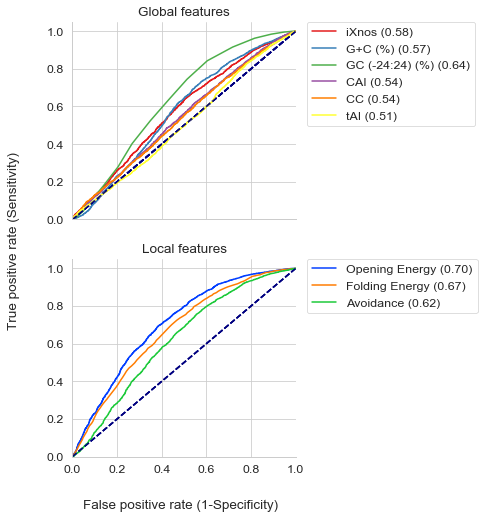

In [45]:
from sklearn.metrics import roc_curve, auc


all_features = pd.read_csv('results/features_and_merged_with_ixnos_dicodone.csv')
df = all_features[['iXnos', 'G+C (%)', 'GC (-24:24) (%)', 'CAI','Genome', 'tAI', ]].copy()

#Rename Genomics to CC (codon context)
df.rename(columns={'Genome':'CC'}, inplace=True)

df1 = all_features[['Accessibility', 'STR(-30:30)','Avoidance(Min_dg_int)']].copy()
df1.rename(columns={'STR(-30:30)': 'Folding Energy', 'Accessibility': 'Opening Energy', 'Avoidance(Min_dg_int)':'Avoidance'}, inplace=True)


df['G+C (%)'] = - df['G+C (%)']
df['GC (-24:24) (%)'] = - df['GC (-24:24) (%)']
df['iXnos'] = -df['iXnos']
df1['Opening Energy'] = - df1['Opening Energy']


labels = all_features.Label.values
plt.figure(0).clf()
lw = 1.5

fig = plt.figure(figsize=(4, 8))


sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)
sns.set_palette("Set1")
plt.subplot(2, 1, 1)

for i, col in enumerate(df.columns):
    preds = df[col].values
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, # c=np.random.rand(3,),
             lw=lw, label=col +' (%0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Global features')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    
    
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)
sns.set_palette("bright")
plt.subplot(2, 1, 2)
for i, col in enumerate(df1.columns):
    preds = df1[col].values
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, # c=np.random.rand(3,),
             lw=lw, label=col +' (%0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Local features')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
    
    

# Make common axis labels
fig.text(0.5, 0.04, 'False positive rate (1-Specificity)', va='center', ha='center')
fig.text(-0.08, 0.5, 'True positive rate (Sensitivity)', va='center', ha='center', rotation='vertical')

sns.despine()
plt.savefig("figs/ROC_features_all.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()


### ROC CI for features

In [31]:
import roc_ci #DeLong method
import scipy.stats

In [46]:
all_features = pd.read_csv('results/features_and_merged_with_ixnos_dicodone.csv')
df = all_features[['iXnos', 'G+C (%)', 'GC (-24:24) (%)', 'CAI', 'tAI', ]].copy()

df1 = all_features[['Accessibility', 'STR(-30:30)','Avoidance(Min_dg_int)']].copy()
df1.rename(columns={'STR(-30:30)': 'Folding Energy', 'Accessibility': 'Opening Energy', 'Avoidance(Min_dg_int)':'Avoidance'}, inplace=True)


df['G+C (%)'] = - df['G+C (%)']
df['iXnos'] = -df['iXnos']
df1['Opening Energy'] = - df1['Opening Energy']

alpha = 0.95 #(95% CI)



In [47]:
#local features
for _, val in enumerate(df1.columns):
    y_pred = df1[val].values
    y_true = all_features.Label.values

    auc, auc_cov = roc_ci.delong_roc_variance(
        y_true,
        y_pred)

    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = scipy.stats.norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)

    ci[ci > 1] = 1

    print(val)
    print('AUC:', auc)
    print('AUC COV:', auc_cov)
    print('95% AUC CI:', ci)

Opening Energy
AUC: 0.7034085399922638
AUC COV: 3.6827391381671346e-05
95% AUC CI: [0.69151439 0.71530269]
Folding Energy
AUC: 0.6710898912623029
AUC COV: 3.847298204191941e-05
95% AUC CI: [0.6589329  0.68324688]
Avoidance
AUC: 0.6198986762367302
AUC COV: 4.333257134408453e-05
95% AUC CI: [0.60699673 0.63280063]


In [48]:
#global features
for _, val in enumerate(df.columns):
    y_pred = df[val].values
    y_true = all_features.Label.values

    auc, auc_cov = roc_ci.delong_roc_variance(
        y_true,
        y_pred)

    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = scipy.stats.norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)

    ci[ci > 1] = 1

    print(val)
    print('AUC:', auc)
    print('AUC COV:', auc_cov)
    print('95% AUC CI:', ci)

iXnos
AUC: 0.5771699402587354
AUC COV: 4.2090726763533474e-05
95% AUC CI: [0.56445421 0.58988567]
G+C (%)
AUC: 0.5729177160785661
AUC COV: 4.5411949901600164e-05
95% AUC CI: [0.55970983 0.5861256 ]
GC (-24:24) (%)
AUC: 0.36457974814114413
AUC COV: 4.464132843995295e-05
95% AUC CI: [0.35148441 0.37767508]
CAI
AUC: 0.5434927150040831
AUC COV: 4.226231207646763e-05
95% AUC CI: [0.53075109 0.55623434]
tAI
AUC: 0.507045687024541
AUC COV: 4.3002745132643324e-05
95% AUC CI: [0.49419293 0.51989844]


In [49]:
all_features.head()

,Accession,Sequence,Class,Label,analyze,CAI,tAI,G+C (%),STR(-30:30),Avoidance_unparsed,Accessibility,Avd_parsed_dg_int,Avoidance(Min_dg_int),iXnos,Genome,GC (-24:24) (%)
0,BbCD00385183,ATGCTCACTATCGATACGGCGTCCCGCACTTTTCACTGCAAGACCT...,2.0,1.0,<features.AnalyzeSequenceFeatures object at 0x...,0.287629,0.231803,63.834423,-4.4,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,10.250980,[[ -6.8 -25.55 -13.9 -14.5 -18.81 -15.82 -2...,-27.46,1.207039,0.093878,39.583333
1,BbCD00385184,ATGACCCTGAAAACCATGACGCTGGCTTTTGCCGTAACCGGCCTTG...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.331518,0.232533,58.943089,-3.8,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,9.809347,[[ -8.1 -6.8 -7.76 -6.3 -26.64 -9.8 -...,-26.64,1.070245,0.102099,37.500000
2,BcCD00540749,ATGAACGGGAAGCAAGTAAACAATGTGGAAGGCGTTGTCACAGCGC...,2.0,1.0,<features.AnalyzeSequenceFeatures object at 0x...,0.264601,0.221840,39.866667,-3.6,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,5.627092,[[-11.31 -4.5 -7. -5.6 -8.8 -5.9 -...,-18.62,0.839034,0.087809,31.250000
3,BcCD00583995,ATGGGAGATAAATATATTACTGTTCAAAAAGTCGGTAAGAAAATAT...,2.0,1.0,<features.AnalyzeSequenceFeatures object at 0x...,0.284978,0.194533,35.103245,-3.9,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,8.872705,[[ -3.2 -6.6 -6. -4.2 -2.7 -2.7 -...,-22.77,0.764515,0.109747,25.000000
4,BsCD00423013,ATGAGCTTGCAATTTAGCGTACTTGCGAGCGGGAGTACGGGAAATG...,1.0,1.0,<features.AnalyzeSequenceFeatures object at 0x...,0.250264,0.192802,48.255114,-10.5,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,11.673680,[[ -6.2 -1.8 -6.9 -4.9 -6.2 -6.2 -...,-12.60,0.938175,0.105492,31.250000


# Correlations

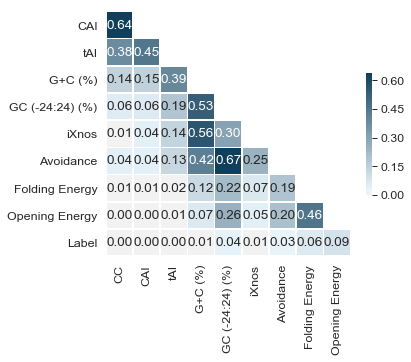

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)

#all_features = pd.read_csv('results/features_for_all_sequences.csv')
d = all_features[['Genome','CAI','tAI', 'G+C (%)', 'GC (-24:24) (%)', 'iXnos','Avoidance(Min_dg_int)',\
                  'STR(-30:30)','Accessibility', 'Label']].copy()
d.rename(columns={'Genome':'CC','STR(-30:30)': 'Folding Energy', 'Accessibility': 'Opening Energy',\
                  'Avoidance(Min_dg_int)':'Avoidance'}, inplace=True)


# Compute the correlation matrix
corr = d.corr(method='spearman')

#squared correlation
corr_sq = corr*corr

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_sq, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5.5,4.5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 240, s=90, l=25,as_cmap=True)
#cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
#cmap = sns.cubehelix_palette(50, as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_sq, mask=mask, cmap=cmap, vmax=.64, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
ax.set_xlim(0,9)
ax.set_ylim(10,1)
plt.savefig("figs/Correlation_heatmap_features_all.pdf", bbox_inches = 'tight', pad_inches=0)

In [51]:
from scipy import stats

df_corr = pd.DataFrame() # Correlation matrix
df_p = pd.DataFrame()  # Matrix of p-values
for x in d.columns:
    for y in d.columns:
        corr1 = stats.spearmanr(d[x], d[y])
        df_corr.loc[x,y] = corr1[0]
        df_p.loc[x,y] = corr1[1]

In [52]:
#P-values for correlation above
bonferroni_ = len(df_corr)*(len(df_corr)-1)/2

(df_p*bonferroni_)

,CC,CAI,tAI,G+C (%),GC (-24:24) (%),iXnos,Avoidance,Folding Energy,Opening Energy,Label
CC,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.244407e-144,4.610671e-35,1.251644e-107,6.294180e-17,1.506769e+00,1.388512e-07
CAI,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.517784e-159,1.287753e-104,2.009313e-105,1.564818e-14,7.364194e-02,4.587844e-10
tAI,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.557498e-56,2.595929e-13,1.218848e+01
G+C (%),0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.228293e-304,5.330247e-169,1.366563e-28
GC (-24:24) (%),9.244407e-144,6.517784e-159,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.568721e-100
iXnos,4.610671e-35,1.287753e-104,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.748170e-185,1.422658e-116,4.846629e-32
Avoidance,1.251644e-107,2.009313e-105,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.007597e-78
Folding Energy,6.294180e-17,1.564818e-14,3.557498e-56,2.228293e-304,0.000000e+00,7.748170e-185,0.000000e+00,0.000000e+00,0.000000e+00,6.189443e-161
Opening Energy,1.506769e+00,7.364194e-02,2.595929e-13,5.330247e-169,0.000000e+00,1.422658e-116,0.000000e+00,0.000000e+00,0.000000e+00,2.043899e-230
Label,1.388512e-07,4.587844e-10,1.218848e+01,1.366563e-28,1.568721e-100,4.846629e-32,7.007597e-78,6.189443e-161,2.043899e-230,0.000000e+00


In [53]:
#P-values for correlation above
bonferroni_ = len(df_corr)*(len(df_corr)-1)/2
bonferroni_

45.0

In [54]:
df_corr.round(4)

,CC,CAI,tAI,G+C (%),GC (-24:24) (%),iXnos,Avoidance,Folding Energy,Opening Energy,Label
CC,1.0000,0.7990,0.6173,0.3790,0.2368,0.1180,-0.2055,-0.0822,0.0199,0.0554
CAI,0.7990,1.0000,0.6737,0.3839,0.2486,0.2027,-0.2035,-0.0762,0.0295,0.0636
tAI,0.6173,0.6737,1.0000,0.6277,0.4331,0.3705,-0.3587,-0.1491,0.0730,0.0103
G+C (%),0.3790,0.3839,0.6277,1.0000,0.7314,0.7473,-0.6488,-0.3394,0.2561,-0.1066
GC (-24:24) (%),0.2368,0.2486,0.4331,0.7314,1.0000,0.5508,-0.8211,-0.4738,0.5051,-0.1988
iXnos,0.1180,0.2027,0.3705,0.7473,0.5508,1.0000,-0.4957,-0.2675,0.2137,-0.1128
Avoidance,-0.2055,-0.2035,-0.3587,-0.6488,-0.8211,-0.4957,1.0000,0.4374,-0.4515,0.1753
Folding Energy,-0.0822,-0.0762,-0.1491,-0.3394,-0.4738,-0.2675,0.4374,1.0000,-0.6751,0.2501
Opening Energy,0.0199,0.0295,0.0730,0.2561,0.5051,0.2137,-0.4515,-0.6751,1.0000,-0.2974
Label,0.0554,0.0636,0.0103,-0.1066,-0.1988,-0.1128,0.1753,0.2501,-0.2974,1.0000


# Accessibility for randomly generated sequences

In [412]:
import data

def syn_seq(seq):
    start = seq[:3]
    stop = seq[-3:]
    seq = seq[3:-3].upper()
    length = len(seq) - len(seq)%3
    codons = functions.splitter(seq, length)

    rnd_state = np.random.RandomState(12345)
    syn_seq = ''
    for ind, codon in enumerate(codons):
        possible_codons = data.AA_TO_CODON[data.CODON_TO_AA[codon]]
        syn_seq += rnd_state.choice(possible_codons)
    return start+syn_seq+stop

In [414]:
#failed sequences dataframe
failed = all_features.loc[all_features['Label']==0].copy()

#generate random syn seq for failed sequence
failed['Synonymous_seq'] = failed['Sequence'].apply(syn_seq)

In [416]:
#make seperate dataframe for generated synonymous sequences

failed_syn_seq = failed[['Accession', 'Label', 'Synonymous_seq']].copy()
failed_syn_seq.to_csv('results/failed_rnd_syn.csv', index=None)

In [417]:
def df_access_calc(df):
    df['Accessibility'] = df['Analyse_features'].apply(lambda x: x.access_calc())
    return df


In [419]:
failed_syn_seq['Analyse_features'] = failed_syn_seq.Synonymous_seq.apply(features.AnalyzeSequenceFeatures)
failed_syn_seq_accs = functions.parallelize_df(failed_syn_seq, df_features)

In [592]:
failed_syn_seq_accs.to_csv('results/failed_rnd_syn_accs.csv', index=None)
failed_syn_seq_accs.rename(columns={'Accessibility':'Accs_syn'}, inplace=True)

In [454]:
failed_syn_seq_accs.head()

,Accession,Label,Synonymous_seq,Analyse_features,Accs_syn
1,BbCD00385184,0.0,ATGACACTAAAAACCATGACTTTGGCATTTGCCGTAACCGGCTTGG...,<features.AnalyzeSequenceFeatures object at 0x...,6.833192
7,CaCD00344362,0.0,ATGCTTTTCATCATCAAGTACTATGAACCCAAGAACTTGTATGAGC...,<features.AnalyzeSequenceFeatures object at 0x...,8.933866
17,DhCD00338941,0.0,ATGCCACAGGAGGGCCTGCGCTTTGTAGTCCAACACCACTTGGCGC...,<features.AnalyzeSequenceFeatures object at 0x...,11.967740
26,EcCD00331370,0.0,ATGCCAGGCAACTCCCCTCACTATGGAAGGTGGCCACAGCACGATT...,<features.AnalyzeSequenceFeatures object at 0x...,12.663110
28,LbCD00598846,0.0,ATGCTTGGCAGGTCCGATGTCGGAAGGACAGACACCTTGATGGTGG...,<features.AnalyzeSequenceFeatures object at 0x...,11.657140


### Optimise initial  10 only

In [428]:
import opt
rand_states = np.random.RandomState(12345)
plfold_args='-W 210 -u 50 -O'
pET21_UTR = 'GGGGAATTGTGAGCGGATAACAATTCCCCTCTAGAAATAATTTTGTTTAACTTTAAGAAGGAGATATACAT'

def df_primer_opt(df):
    df['Optimised_seq'] = df['optimiser'].apply(lambda x:x.simulated_anneal(rand_state=rand_states))
    return df


In [429]:
failed['optimiser'] = failed['Sequence'].apply(lambda x:opt.Optimizer(seq=x, utr=pET21_UTR, plfold_args=plfold_args))


In [430]:
failed_optimised = functions.parallelize_df(failed, df_primer_opt)
failed_optimised.to_csv('results/failed_optimised_SA.csv', index=None)

In [432]:
failed_optimised.to_csv('results/failed_optimised_SA.csv', index=None)

In [613]:
failed_optimised_df = failed_optimised[['Accession', 'Optimised_seq']].copy()
failed_optimised_df[['Optimised_sequence', 'Accessibility']] = pd.DataFrame(failed_optimised_df['Optimised_seq'].tolist(), index=failed_optimised_df.index)
failed_optimised_df.head()

,Accession,Optimised_seq,Optimised_sequence,Accessibility
1,BbCD00385184,(ATGACATTAAAAACCATGACCCTAGCTTTCGCCGTAACCGGCCTT...,ATGACATTAAAAACCATGACCCTAGCTTTCGCCGTAACCGGCCTTG...,4.202636
7,CaCD00344362,(ATGTTATTCATAATTAAATACTACGAGCCGAAGAACCTATATGAG...,ATGTTATTCATAATTAAATACTACGAGCCGAAGAACCTATATGAGC...,5.798749
17,DhCD00338941,(ATGCCACAAGAAGGGTTACGATTCGTGGTGCAGCACCATCTGGCC...,ATGCCACAAGAAGGGTTACGATTCGTGGTGCAGCACCATCTGGCCC...,8.783537
26,EcCD00331370,(ATGCCAGGAAACTCACCACACTACGGCCGATGGCCTCAACACGAT...,ATGCCAGGAAACTCACCACACTACGGCCGATGGCCTCAACACGATT...,5.986135
28,LbCD00598846,(ATGCTTGGTAGATCAGATGTTGGGCGAACCGACACCTTGATGGTT...,ATGCTTGGTAGATCAGATGTTGGGCGAACCGACACCTTGATGGTTG...,6.863647


In [614]:
failed_optimised_df.rename(columns={'Accessibility':'Accs_opt_sa'}, inplace=True)

In [947]:
failed_optimised_df.to_csv('results/failed_optimised_len_10.csv', index=None)

# COOL optimised sequences

In [168]:
cool = pd.read_csv('COOL_optimised_TT.csv')
cool.head()

,Sequence
0,AUGACGUUAAAAACCAUGACCCUGGCAUUCGCUGUGACUGGUCUGG...
1,AUGCUGUUCAUUAUUAAAUACUACGAACCUAAAAACCUGUAUGAAC...
2,AUGCCGCAGGAAGGCUUACGCUUCGUUGUUCAACAUCAUCUUGCCC...
3,AUGCCGGGUAAUUCUCCGCACUACGGUAGAUGGCCCCAACAUGAUU...
4,AUGCUGGGCCGCAGCGACGUCGGUCGCACGGAUACGUUAAUGGUGG...


In [169]:
cool['Sequence'][0]

'AUGACGUUAAAAACCAUGACCCUGGCAUUCGCUGUGACUGGUCUGGGGGUGCUGGCCGGCUGCUCGUCUCCGAGCGUUGUGCAGCAGCGCGAUGGCUCCCAGGUGGUGACCCCGGAUGAACCUAAAUAUAACGAAGAUACCGGCUUUUAUGAAUACGAAAAGGAUGGUCAUAAAGUUCAGAUGAAUAAAGAUGAUGUGAAGACCAUUGAAGAAGUGAAACUCGAACAUCACCACCAUCAUCAUUAA'

In [170]:
#Accessibility functions
import os
from multiprocessing import Pool, cpu_count
from subprocess import run, PIPE, DEVNULL
import secrets
import string
import tempfile


def accession_gen():
    '''Random accession numbers
    '''
    rand_string = ''.join(secrets.choice(string.ascii_uppercase + \
                                        string.digits) for _ in range(10))
    accession = '>' + rand_string + '\n'
    return accession, rand_string


def access_calc(seq, utr=None):
    '''Sequence accessibility
    '''
    tmp = os.path.join(tempfile.gettempdir(), 'plfold')
    
    nt_pos = 24 #the length to check accessibility values (30nt upstream)
    subseg_length = 48
    
    
    try:
        os.makedirs(tmp)
    except FileExistsError:
        pass
    if utr is None:
        utr = 'GGGGAATTGTGAGCGGATAACAATTCCCCTCTAGAAATAATTTTGTTTAACTTTAAGAAGGAGATATACAT'
    else:
        utr = utr.upper()
  
    sequence = utr + seq
    seq_accession, rand_string = accession_gen()
    input_seq = seq_accession + sequence
    run(['RNAplfold', '-W 210', '-u 50', '-O'], \
               stdout=PIPE, stderr=DEVNULL, input=input_seq, cwd=tmp, \
                encoding='utf-8')
    out1 = '/' + rand_string + '_openen'
    out2 = '/' + rand_string + '_dp.ps'
    #open_en = pd.read_csv(tmp+out1, sep='\t', skiprows=2, header=None)\
    #            .iloc[94][48] #for 0(ATG) to 13  nts to the left.

    open_en = pd.read_csv(tmp+out1, sep='\t', skiprows=2, header=None)\
                [subseg_length][len(utr) + nt_pos - 1] #-23 to 24 : row = len(utr)+24-1(because python starts from 0)
                                        #: column = 23+24+1 (region from 24nt to -23nt is free, \
                                            #for plfold, col# = nt to col#-1 free)
    os.remove(tmp+out1)
    os.remove(tmp+out2)
    return open_en



def parallelize_df(df, func):
    '''parallelizes operations on a dataframe by splitting it to chunks
    '''
    partitions = cpu_count()
    df_split = np.array_split(df, partitions)
    pool = Pool(partitions)
    results = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return results



def df_features(df, utr=None):
    df['Accessibility_cool'] = df['Sequence'].apply(lambda x: access_calc(x, utr))
    return df






In [171]:
res_df_cool = parallelize_df(cool, df_features)

In [172]:
cool_accs = res_df_cool.rename(columns={'Sequence':'CoolOptimised','Accessibility_cool':'Access_cool'})

In [173]:
cool_accs.head()

,CoolOptimised,Access_cool
0,AUGACGUUAAAAACCAUGACCCUGGCAUUCGCUGUGACUGGUCUGG...,7.066478
1,AUGCUGUUCAUUAUUAAAUACUACGAACCUAAAAACCUGUAUGAAC...,8.002097
2,AUGCCGCAGGAAGGCUUACGCUUCGUUGUUCAACAUCAUCUUGCCC...,10.964970
3,AUGCCGGGUAAUUCUCCGCACUACGGUAGAUGGCCCCAACAUGAUU...,14.508960
4,AUGCUGGGCCGCAGCGACGUCGGUCGCACGGAUACGUUAAUGGUGG...,15.686090


In [174]:
cool_accs.to_csv('COOL_optimised_TT_with_accs.csv', index=None)

In [175]:
cool_accs['CoolOptimised'][0]

'AUGACGUUAAAAACCAUGACCCUGGCAUUCGCUGUGACUGGUCUGGGGGUGCUGGCCGGCUGCUCGUCUCCGAGCGUUGUGCAGCAGCGCGAUGGCUCCCAGGUGGUGACCCCGGAUGAACCUAAAUAUAACGAAGAUACCGGCUUUUAUGAAUACGAAAAGGAUGGUCAUAAAGUUCAGAUGAAUAAAGAUGAUGUGAAGACCAUUGAAGAAGUGAAACUCGAACAUCACCACCAUCAUCAUUAA'

## Combine failed sequences, randomly generated sequences and optimised sequences

In [178]:
all_features = pd.read_csv('results/features_and_merged_with_ixnos_dicodone.csv')
failed = all_features.loc[all_features['Label']==0].copy()
success = all_features.loc[all_features['Label']==1]
failed.shape

(2650, 15)

In [180]:
#VERY IMPORTANT STEP. RESET INDEX OR YOU WILL GET NaNs FOR DISCONTINUOUS INDEX

failed = failed.reset_index(drop=True)
failed

,Accession,Sequence,Class,Label,analyze,CAI,tAI,G+C (%),STR(-30:30),Avoidance_unparsed,Accessibility,Avd_parsed_dg_int,Avoidance(Min_dg_int),iXnos,Genome
0,BbCD00385184,ATGACCCTGAAAACCATGACGCTGGCTTTTGCCGTAACCGGCCTTG...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.331518,0.232533,58.943089,-3.800000,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,9.809347,[[ -8.1 -6.8 -7.76 -6.3 -26.64 -9.8 -...,-26.64,1.070245,0.102099
1,CaCD00344362,ATGCTTTTTATTATAAAATACTATGAACCTAAGAACCTATATGAGC...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.190337,0.184653,32.558140,-4.300000,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,7.155166,[[-9.44 -7.81 -6.1 -8.5 -8.1 -8.2 -8.2 -7...,-9.44,0.866962,0.064345
2,DhCD00338941,ATGCCCCAGGAGGGGCTGAGGTTTGTAGTGCAGCACCATCTGGCCC...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.206587,0.213042,53.240741,-12.300000,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,16.990780,[[ -4.4 -3.6 -8.8 -5.5 -5.5 -3.1 -...,-30.14,0.818382,0.089142
3,EcCD00331370,ATGCCGGGCAACAGCCCGCATTATGGGCGTTGGCCTCAACACGATT...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.246634,0.218314,54.924242,-13.700000,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,16.552800,[[ -6.7 -5.5 -8.11 -14.7 -14.7 -11.91 -1...,-32.54,0.922181,0.110757
4,LbCD00598846,ATGTTAGGACGTTCTGATGTCGGCCGAACCGACACCTTGATGGTTG...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.272670,0.200048,46.958637,-6.800000,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,9.037042,[[-19.95 -9.7 -13.2 -6.1 -8.7 -9.72 -...,-28.90,1.064395,0.082636
5,MmCD00334948,ATGGTGCATACTCCTCTGAATTTCAAATTCTCTGAAAAAAGAGAAG...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.257279,0.205162,47.270115,-8.400000,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,12.311680,[[ -6.1 -8. -4.7 -8.49 -9.9 -10.6 -1...,-21.17,0.921119,0.085199
6,MmCD00334949,ATGGTAATATTTATTATGAAAAAAAGGTATATTTGTATATTGCCAT...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.190692,0.197901,42.285041,-3.000000,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,10.518550,[[ -3.2 -3.5 -9.34 -4.9 -4.9 -3.5 -...,-12.58,0.841903,0.080177
7,MmCD00591395,ATGGGCGATTTCGTGCTCGACGTTGGCTGTGGAACAGGGAGGCAGG...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.202700,0.200935,48.707483,-10.100000,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,13.171700,[[-10.6 -6.8 -9.8 -22.53 -10.3 -2.7 -1...,-25.72,0.962835,0.072153
8,NeCD00591391,ATGGCCGGTCCGTCGCTGGTTGAAGTTGCTGCTGCCGTTCTCATTC...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.287707,0.202111,55.625000,-9.200000,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,11.625930,[[ -7.43 -23.61 -9.82 -6.5 -23.77 -9.6 -2...,-30.20,1.019755,0.091344
9,NeCD00605601,ATGCCGATTCGCAGTTATGTGCTCCGTCAGGGATATTTTTCCAATG...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.290425,0.220596,54.148472,-11.900000,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,12.979670,[[-10.2 -7.8 -8.4 -19.06 -20.83 -19.11 -1...,-21.78,1.024676,0.118713


In [223]:
failed.to_csv('results/failed_seq_2650.csv', columns=['Accession','Sequence'] ,index=None)

In [225]:
for_mrnaopt = failed.copy()

In [226]:
for_mrnaopt['Sequence'] = for_mrnaopt['Sequence'].apply(lambda x:x.replace('T','U'))

In [227]:
for_mrnaopt.head()

,Accession,Sequence,Class,Label,analyze,CAI,tAI,G+C (%),STR(-30:30),Avoidance_unparsed,Accessibility,Avd_parsed_dg_int,Avoidance(Min_dg_int),iXnos,Genome
0,BbCD00385184,AUGACCCUGAAAACCAUGACGCUGGCUUUUGCCGUAACCGGCCUUG...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.331518,0.232533,58.943089,-3.8,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,9.809347,[[ -8.1 -6.8 -7.76 -6.3 -26.64 -9.8 -...,-26.64,1.070245,0.102099
1,CaCD00344362,AUGCUUUUUAUUAUAAAAUACUAUGAACCUAAGAACCUAUAUGAGC...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.190337,0.184653,32.558140,-4.3,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,7.155166,[[-9.44 -7.81 -6.1 -8.5 -8.1 -8.2 -8.2 -7...,-9.44,0.866962,0.064345
2,DhCD00338941,AUGCCCCAGGAGGGGCUGAGGUUUGUAGUGCAGCACCAUCUGGCCC...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.206587,0.213042,53.240741,-12.3,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,16.990780,[[ -4.4 -3.6 -8.8 -5.5 -5.5 -3.1 -...,-30.14,0.818382,0.089142
3,EcCD00331370,AUGCCGGGCAACAGCCCGCAUUAUGGGCGUUGGCCUCAACACGAUU...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.246634,0.218314,54.924242,-13.7,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,16.552800,[[ -6.7 -5.5 -8.11 -14.7 -14.7 -11.91 -1...,-32.54,0.922181,0.110757
4,LbCD00598846,AUGUUAGGACGUUCUGAUGUCGGCCGAACCGACACCUUGAUGGUUG...,0.0,0.0,<features.AnalyzeSequenceFeatures object at 0x...,0.272670,0.200048,46.958637,-6.8,>input_mrna:break\n>ECD_RS01040_tRNA-Ile_GAT\n...,9.037042,[[-19.95 -9.7 -13.2 -6.1 -8.7 -9.72 -...,-28.90,1.064395,0.082636


In [229]:
for_mrnaopt.to_csv('results/for_mrna_opt_failed_seq_2650.csv', columns=['Accession','Sequence', 'Accessibility'] ,index=None)

In [181]:

failed_syn_seq_accs = pd.read_csv('results/failed_rnd_syn_accs.csv')
failed_optimised_df = pd.read_csv('results/failed_optimised_len_10.csv')


In [182]:

#make dataframe of failed, random seq and optimised sequence with their accessibility
failed_rand_and_opt_df = pd.concat([failed[['Accession', 'Label', 'Sequence', 'Accessibility']],\
           failed_syn_seq_accs[['Synonymous_seq', 'Accs_syn']], \
           failed_optimised_df[['Optimised_sequence','Accs_opt_sa']],cool_accs[['CoolOptimised',\
                                                                                'Access_cool']] ], axis=1)
failed_rand_and_opt_df.to_csv('results/failed_seq_rand_cool_and_optimised.csv', index=None)

In [183]:
failed_rand_and_opt_df.head()

,Accession,Label,Sequence,Accessibility,Synonymous_seq,Accs_syn,Optimised_sequence,Accs_opt_sa,CoolOptimised,Access_cool
0,BbCD00385184,0.0,ATGACCCTGAAAACCATGACGCTGGCTTTTGCCGTAACCGGCCTTG...,9.809347,ATGACACTAAAAACCATGACTTTGGCATTTGCCGTAACCGGCTTGG...,6.833192,ATGACATTAAAAACCATGACCCTAGCTTTCGCCGTAACCGGCCTTG...,4.202636,AUGACGUUAAAAACCAUGACCCUGGCAUUCGCUGUGACUGGUCUGG...,7.066478
1,CaCD00344362,0.0,ATGCTTTTTATTATAAAATACTATGAACCTAAGAACCTATATGAGC...,7.155166,ATGCTTTTCATCATCAAGTACTATGAACCCAAGAACTTGTATGAGC...,8.933866,ATGTTATTCATAATTAAATACTACGAGCCGAAGAACCTATATGAGC...,5.798749,AUGCUGUUCAUUAUUAAAUACUACGAACCUAAAAACCUGUAUGAAC...,8.002097
2,DhCD00338941,0.0,ATGCCCCAGGAGGGGCTGAGGTTTGTAGTGCAGCACCATCTGGCCC...,16.990780,ATGCCACAGGAGGGCCTGCGCTTTGTAGTCCAACACCACTTGGCGC...,11.967740,ATGCCACAAGAAGGGTTACGATTCGTGGTGCAGCACCATCTGGCCC...,8.783537,AUGCCGCAGGAAGGCUUACGCUUCGUUGUUCAACAUCAUCUUGCCC...,10.964970
3,EcCD00331370,0.0,ATGCCGGGCAACAGCCCGCATTATGGGCGTTGGCCTCAACACGATT...,16.552800,ATGCCAGGCAACTCCCCTCACTATGGAAGGTGGCCACAGCACGATT...,12.663110,ATGCCAGGAAACTCACCACACTACGGCCGATGGCCTCAACACGATT...,5.986135,AUGCCGGGUAAUUCUCCGCACUACGGUAGAUGGCCCCAACAUGAUU...,14.508960
4,LbCD00598846,0.0,ATGTTAGGACGTTCTGATGTCGGCCGAACCGACACCTTGATGGTTG...,9.037042,ATGCTTGGCAGGTCCGATGTCGGAAGGACAGACACCTTGATGGTGG...,11.657140,ATGCTTGGTAGATCAGATGTTGGGCGAACCGACACCTTGATGGTTG...,6.863647,AUGCUGGGCCGCAGCGACGUCGGUCGCACGGAUACGUUAAUGGUGG...,15.686090


In [184]:

#Commercial optimised_sequence (novopro) (see Novoprolabs_get_seq.ipynb)
#out of total 2650 failed, we were able to get optimised sequence for 2573 sequences only
novo_seq = pd.read_csv('Novo_optimised.csv')
novo_df = novo_seq[['Accession', 'NovoProOptimsed', 'Accessibility_N']].copy()

In [185]:
failed_total_df = pd.merge(failed_rand_and_opt_df, novo_df, on='Accession')

In [186]:
failed_total_df.tail()

,Accession,Label,Sequence,Accessibility,Synonymous_seq,Accs_syn,Optimised_sequence,Accs_opt_sa,CoolOptimised,Access_cool,NovoProOptimsed,Accessibility_N
2568,XfCD00598858,0.0,ATGCGGATTCACCCCTTACTTACTTACACTTCGCCGATGCCCGGCT...,6.249232,ATGCGAATCCACCCCCTGTTGACATATACCTCACCCATGCCCGGAT...,6.241708,ATGCGCATACACCCCCTACTAACCTACACCTCGCCGATGCCCGGCT...,3.564955,AUGCGUAUCCACCCGCUGCUGACCUACACCAGCCCGAUGCCGGGUA...,7.113295,ATGCGTATTCACCCACTGCTGACGTATACCTCCCCAATGCCAGGTA...,10.551360
2569,XfCD00665723,0.0,ATGAATGCGGTGCAAGTGCAAGCCAGTCAGCCGGTAACGTTTAGTG...,9.238688,ATGAATGCCGTCCAGGTTCAGGCAAGCCAACCCGTCACATTCTCGG...,10.327120,ATGAACGCGGTACAAGTACAAGCAAGCCAACCGGTAACGTTTAGTG...,5.519618,AUGAACGCCGUACAGGUUCAGGCAAGCCAGCCGGUAACGUUUUCUG...,10.574430,ATGAACGCGGTGCAAGTTCAGGCATCTCAGCCTGTTACCTTCTCTG...,11.239240
2570,YeCD00540349,0.0,ATGCTTGTTCGTAAAGTATGCCAAAATTTTTTCCAGAATGCCTTAG...,12.740820,ATGCTTGTCAGGAAAGTTTGCCAAAATTTCTTTCAGAACGCATTGG...,11.528730,ATGCTTGTCCGAAAAGTCTGCCAAAATTTCTTCCAGAATGCCTTAG...,8.271632,AUGCUAGUGCGUAAAGUUUGCCAGAACUUCUUCCAGAAUGCGCUGG...,12.471590,ATGCTGGTTCGCAAAGTGTGCCAGAACTTTTTCCAAAACGCGCTGG...,13.610020
2571,YeCD00540350,0.0,ATGCTTGTTCGTAAAGTATGCCAAAATTTTTTCCAGAATGCCTTAG...,12.740820,ATGCTTGTCAGGAAAGTTTGCCAAAATTTCTTTCAGAACGCATTGG...,11.528730,ATGCTAGTTCGAAAGGTCTGTCAAAATTTTTTCCAGAATGCCTTAG...,8.557076,AUGCUGGUUCGUAAAGUUUGCCAGAACUUUUUCCAGAAUGCGCUGG...,13.140170,ATGCTGGTACGCAAAGTATGCCAGAACTTCTTTCAGAACGCACTGG...,13.737620
2572,YeCD00665644,0.0,ATGGAACATACGCTACAAGCCGTTGCTCGAAAGTGGTTAGATGAGA...,8.707601,ATGGAACACACCTTGCAAGCCGTAGCAAGGAAGTGGCTAGACGAAA...,12.405510,ATGGAACATACATTACAAGCTGTAGCTCGCAAGTGGTTAGATGAGA...,7.373694,AUGGAACAUACCCUGCAGGCCGUCGCCCGCAAAUGGCUGGAUGAGA...,9.894840,ATGGAACATACCCTGCAAGCGGTTGCACGCAAATGGCTGGATGAGA...,8.335983


In [187]:
failed_total_df.to_csv('results/failed_comm_rand_opt_cool.csv',  index=None)

In [188]:
failed_total_df.head()

,Accession,Label,Sequence,Accessibility,Synonymous_seq,Accs_syn,Optimised_sequence,Accs_opt_sa,CoolOptimised,Access_cool,NovoProOptimsed,Accessibility_N
0,BbCD00385184,0.0,ATGACCCTGAAAACCATGACGCTGGCTTTTGCCGTAACCGGCCTTG...,9.809347,ATGACACTAAAAACCATGACTTTGGCATTTGCCGTAACCGGCTTGG...,6.833192,ATGACATTAAAAACCATGACCCTAGCTTTCGCCGTAACCGGCCTTG...,4.202636,AUGACGUUAAAAACCAUGACCCUGGCAUUCGCUGUGACUGGUCUGG...,7.066478,ATGACCCTGAAAACGATGACTCTGGCGTTCGCAGTAACCGGTCTGG...,7.934252
1,CaCD00344362,0.0,ATGCTTTTTATTATAAAATACTATGAACCTAAGAACCTATATGAGC...,7.155166,ATGCTTTTCATCATCAAGTACTATGAACCCAAGAACTTGTATGAGC...,8.933866,ATGTTATTCATAATTAAATACTACGAGCCGAAGAACCTATATGAGC...,5.798749,AUGCUGUUCAUUAUUAAAUACUACGAACCUAAAAACCUGUAUGAAC...,8.002097,ATGCTGTTTATTATCAAATACTATGAACCTAAAAACCTGTACGAGC...,7.790858
2,DhCD00338941,0.0,ATGCCCCAGGAGGGGCTGAGGTTTGTAGTGCAGCACCATCTGGCCC...,16.990780,ATGCCACAGGAGGGCCTGCGCTTTGTAGTCCAACACCACTTGGCGC...,11.967740,ATGCCACAAGAAGGGTTACGATTCGTGGTGCAGCACCATCTGGCCC...,8.783537,AUGCCGCAGGAAGGCUUACGCUUCGUUGUUCAACAUCAUCUUGCCC...,10.964970,ATGCCGCAGGAAGGTCTGCGTTTCGTTGTTCAACATCATCTGGCAC...,12.074790
3,EcCD00331370,0.0,ATGCCGGGCAACAGCCCGCATTATGGGCGTTGGCCTCAACACGATT...,16.552800,ATGCCAGGCAACTCCCCTCACTATGGAAGGTGGCCACAGCACGATT...,12.663110,ATGCCAGGAAACTCACCACACTACGGCCGATGGCCTCAACACGATT...,5.986135,AUGCCGGGUAAUUCUCCGCACUACGGUAGAUGGCCCCAACAUGAUU...,14.508960,ATGCCTGGTAACTCTCCACATTATGGTCGTTGGCCACAGCATGACT...,9.972087
4,LbCD00598846,0.0,ATGTTAGGACGTTCTGATGTCGGCCGAACCGACACCTTGATGGTTG...,9.037042,ATGCTTGGCAGGTCCGATGTCGGAAGGACAGACACCTTGATGGTGG...,11.657140,ATGCTTGGTAGATCAGATGTTGGGCGAACCGACACCTTGATGGTTG...,6.863647,AUGCUGGGCCGCAGCGACGUCGGUCGCACGGAUACGUUAAUGGUGG...,15.686090,ATGCTGGGCCGTAGCGACGTTGGTCGTACTGATACTCTGATGGTTG...,12.702860


In [189]:
failed_total_df['Sequence'][0]

'ATGACCCTGAAAACCATGACGCTGGCTTTTGCCGTAACCGGCCTTGGCGTGTTGGCGGGATGCTCATCGCCCTCGGTGGTACAGCAGCGCGATGGCAGTCAGGTCGTGACGCCCGACGAGCCGAAGTACAACGAGGACACCGGCTTCTACGAGTACGAGAAGGACGGCCACAAGGTCCAGATGAACAAGGACGACGTCAAGACGATCGAGGAGGTCAAGCTCGAGCACCACCACCACCACCACTGA'

In [190]:
failed_total_df['CoolOptimised'][0]

'AUGACGUUAAAAACCAUGACCCUGGCAUUCGCUGUGACUGGUCUGGGGGUGCUGGCCGGCUGCUCGUCUCCGAGCGUUGUGCAGCAGCGCGAUGGCUCCCAGGUGGUGACCCCGGAUGAACCUAAAUAUAACGAAGAUACCGGCUUUUAUGAAUACGAAAAGGAUGGUCAUAAAGUUCAGAUGAAUAAAGAUGAUGUGAAGACCAUUGAAGAAGUGAAACUCGAACAUCACCACCAUCAUCAUUAA'

In [191]:
failed_total_df.shape

(2573, 12)

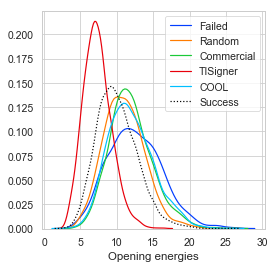

In [193]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)
sns.set_palette("bright")
fig = plt.figure(figsize=(4, 4))



failed_total_df = pd.read_csv('results/failed_comm_rand_opt_cool.csv')
sns.distplot(failed_total_df['Accessibility'], hist=False, label='Failed')




sns.distplot(failed_total_df['Accs_syn'], hist=False, label='Random')

sns.distplot(failed_total_df['Accessibility_N'], hist=False, label='Commercial')
sns.distplot(failed_total_df['Accs_opt_sa'], hist=False, label='TISigner')
sns.distplot(failed_total_df['Access_cool'], hist=False, label='COOL',color='#00BFFF')
sns.distplot(all_features.loc[all_features['Label'] == 1]['Accessibility'], hist=False,\
             label='Success', kde_kws={"linestyle":":"}, color='Black')


legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
#frame.set_edgecolor('black')
plt.xlabel('Opening energies')
plt.savefig("figs/dist_fail_optz_cool__.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [196]:
failed_total_df.head()

,Accession,Label,Sequence,Accessibility,Synonymous_seq,Accs_syn,Optimised_sequence,Accs_opt_sa,CoolOptimised,Access_cool,NovoProOptimsed,Accessibility_N
0,BbCD00385184,0.0,ATGACCCTGAAAACCATGACGCTGGCTTTTGCCGTAACCGGCCTTG...,9.809347,ATGACACTAAAAACCATGACTTTGGCATTTGCCGTAACCGGCTTGG...,6.833192,ATGACATTAAAAACCATGACCCTAGCTTTCGCCGTAACCGGCCTTG...,4.202636,AUGACGUUAAAAACCAUGACCCUGGCAUUCGCUGUGACUGGUCUGG...,7.066478,ATGACCCTGAAAACGATGACTCTGGCGTTCGCAGTAACCGGTCTGG...,7.934252
1,CaCD00344362,0.0,ATGCTTTTTATTATAAAATACTATGAACCTAAGAACCTATATGAGC...,7.155166,ATGCTTTTCATCATCAAGTACTATGAACCCAAGAACTTGTATGAGC...,8.933866,ATGTTATTCATAATTAAATACTACGAGCCGAAGAACCTATATGAGC...,5.798749,AUGCUGUUCAUUAUUAAAUACUACGAACCUAAAAACCUGUAUGAAC...,8.002097,ATGCTGTTTATTATCAAATACTATGAACCTAAAAACCTGTACGAGC...,7.790858
2,DhCD00338941,0.0,ATGCCCCAGGAGGGGCTGAGGTTTGTAGTGCAGCACCATCTGGCCC...,16.990780,ATGCCACAGGAGGGCCTGCGCTTTGTAGTCCAACACCACTTGGCGC...,11.967740,ATGCCACAAGAAGGGTTACGATTCGTGGTGCAGCACCATCTGGCCC...,8.783537,AUGCCGCAGGAAGGCUUACGCUUCGUUGUUCAACAUCAUCUUGCCC...,10.964970,ATGCCGCAGGAAGGTCTGCGTTTCGTTGTTCAACATCATCTGGCAC...,12.074790
3,EcCD00331370,0.0,ATGCCGGGCAACAGCCCGCATTATGGGCGTTGGCCTCAACACGATT...,16.552800,ATGCCAGGCAACTCCCCTCACTATGGAAGGTGGCCACAGCACGATT...,12.663110,ATGCCAGGAAACTCACCACACTACGGCCGATGGCCTCAACACGATT...,5.986135,AUGCCGGGUAAUUCUCCGCACUACGGUAGAUGGCCCCAACAUGAUU...,14.508960,ATGCCTGGTAACTCTCCACATTATGGTCGTTGGCCACAGCATGACT...,9.972087
4,LbCD00598846,0.0,ATGTTAGGACGTTCTGATGTCGGCCGAACCGACACCTTGATGGTTG...,9.037042,ATGCTTGGCAGGTCCGATGTCGGAAGGACAGACACCTTGATGGTGG...,11.657140,ATGCTTGGTAGATCAGATGTTGGGCGAACCGACACCTTGATGGTTG...,6.863647,AUGCUGGGCCGCAGCGACGUCGGUCGCACGGAUACGUUAAUGGUGG...,15.686090,ATGCTGGGCCGTAGCGACGTTGGTCGTACTGATACTCTGATGGTTG...,12.702860


### K-S test

In [197]:
from scipy.stats import ks_2samp

In [198]:
u = success['Accessibility'] #success
v = failed_total_df['Accessibility'] #failed
w = failed_total_df['Accs_syn'] #random
x = failed_total_df['Accessibility_N'] #Novopro
y = failed_total_df['Accs_opt_sa'] #SA(9)
z = failed_total_df['Access_cool'] #cool


labels = ['success','random', 'Cool' ,'failed', 'novo', 'SA']
grps =  [u,w,z,v,x,y]
samples = pd.DataFrame(columns=labels)

df_ks = pd.DataFrame()
df_p = pd.DataFrame()
for ind,x in enumerate(samples.columns):
    for ind1,y in enumerate(samples.columns):
        #print(ind, ind1)
        ks1 = ks_2samp(grps[ind],grps[ind1])
        #print(ks1)
        df_ks.loc[x,y] = ks1[0]
        df_p.loc[x,y] = ks1[1]
df_ks.round(4)

,success,random,Cool,failed,novo,SA
success,0.0000,0.1540,0.2539,0.3095,0.2760,0.4381
random,0.1540,0.0000,0.1166,0.2025,0.1267,0.5744
Cool,0.2539,0.1166,0.0000,0.0995,0.0424,0.6467
failed,0.3095,0.2025,0.0995,0.0000,0.1185,0.6557
novo,0.2760,0.1267,0.0424,0.1185,0.0000,0.6817
SA,0.4381,0.5744,0.6467,0.6557,0.6817,0.0000


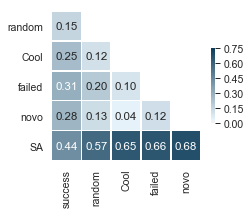

In [217]:
hmap_ks = df_ks[['SA','failed','success','random', 'novo','Cool'  ]].copy()



mask = np.zeros_like(df_ks, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(3.75,2.75))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 240, s=90, l=25, as_cmap=True)
#cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
#cmap = sns.cubehelix_palette(50, as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_ks, mask=mask, cmap=cmap, vmax=.75, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
ax.set_xlim(0,5)
ax.set_ylim(6,1)
plt.savefig("figs/kolmogorov_smirnov_for_failed_optimised_.pdf", bbox_inches = 'tight', pad_inches=0)

In [201]:
bonferroni_ = len(df_ks)*(len(df_ks)-1)/2
bonferroni_

15.0

In [202]:
bonferroni_ = len(df_ks)*(len(df_ks)-1)/2
(df_p*bonferroni_)

,success,random,Cool,failed,novo,SA
success,1.500000e+01,1.909024e-40,2.907580e-111,9.793930e-166,1.356460e-131,0.0
random,1.909024e-40,1.500000e+01,1.519408e-14,2.217603e-45,2.603622e-17,0.0
Cool,2.907580e-111,1.519408e-14,1.500000e+01,2.184323e-10,2.870463e-01,0.0
failed,9.793930e-166,2.217603e-45,2.184323e-10,1.500000e+01,4.651334e-15,0.0
novo,1.356460e-131,2.603622e-17,2.870463e-01,4.651334e-15,1.500000e+01,0.0
SA,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,15.0


In [926]:
#Cooling for simulated annealing

#sns.set_style("whitegrid")
#sns.set_context("paper", font_scale=1.2)
#sns.set_palette("deep")
#fig = plt.figure(figsize=(4, 4))

#x_ax = list(range(0,50))
#sns.lineplot(x_ax, [int((9-1)*np.exp(-_/int(50/2))+1) \
#                         for _ in range(0,50)],  label='Codon substitution')
#sns.lineplot(x_ax, np.geomspace(9, 0.00001, 50), label='Temperature')#drawstyle='steps-pre',
#
#legend = plt.legend(frameon = 1)
#frame = legend.get_frame()
#frame.set_facecolor('white')
#plt.xlabel('No. of iterations')
##plt.ylabel('Max. codon substitution Temperature')
##plt.savefig("figs/Sim_anneal.pdf", bbox_inches = 'tight', pad_inches = 0)
#plt.tick_params(labelright=True)
#plt.show()

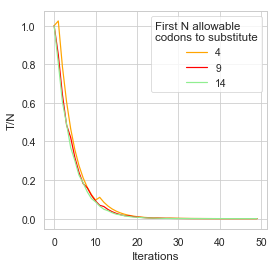

In [205]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)
sns.set_palette("deep")
fig = plt.figure(figsize=(4, 4))

col = ['orange','red', 'lightgreen']

for i,length in enumerate([5,10,15]):
    ncod = length-1
    x_ax = list(range(0,50))
    nsubst = [int((ncod-1)*np.exp(-_/int(50/2))+1) \
                             for _ in range(0,50)]
    temp = np.geomspace(ncod, 0.00001, 50)


    frac=[]
    for _,a in enumerate(nsubst):
        frac.append(temp[_]/a)

    sns.lineplot(x_ax, frac, label=ncod, color=col[i])

legend = plt.legend(frameon = 1, title='First N allowable\ncodons to substitute')
frame = legend.get_frame()
frame.set_facecolor('white')
plt.xlabel('Iterations')
plt.ylabel('T/N')
plt.savefig("figs/Sim_anneal.pdf", bbox_inches = 'tight', pad_inches = 0)

plt.show()